# Implementation of the Boruta Feature Selection Algorithm

In [1]:
# important libraries
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## Reading and processing the data

In [2]:
data =  pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Data processing
 
- Removing NaNs
- Convert categorical variables to numeric representation
- Drop Useless columns


In [4]:
# converting to numeric
data["gender"] = pd.factorize(data["gender"])[0]
data["ever_married"] = pd.factorize(data["ever_married"])[0]
data["work_type"] = pd.factorize(data["work_type"])[0]
data["Residence_type"] = pd.factorize(data["Residence_type"])[0]
data["smoking_status"] = pd.factorize(data["smoking_status"])[0]
# additional cleaning
data.dropna(inplace =True)
data.drop("id", axis =1, inplace = True)
data.reset_index(inplace=True, drop=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,0,0,0,228.69,36.6,0,1
1,0,80.0,0,1,0,0,1,105.92,32.5,1,1
2,1,49.0,0,0,0,0,0,171.23,34.4,2,1
3,1,79.0,1,0,0,1,1,174.12,24.0,1,1
4,0,81.0,0,0,0,0,0,186.21,29.0,0,1


Seperate Input and Output columns

In [5]:
# seperate input and output variables
X = data.drop("stroke", axis = 1)
y = data["stroke"]

## Create shadow features

Shadow features are created by randomly shuffling the original features (row-by-row).

Each shuffled feature is then appended back to the original dataset

In [6]:
for col in X.columns:
    X[f"shadow_{col}"] = X[col].sample(frac=1).reset_index(drop=True)

In [7]:
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,shadow_gender,shadow_age,shadow_hypertension,shadow_heart_disease,shadow_ever_married,shadow_work_type,shadow_Residence_type,shadow_avg_glucose_level,shadow_bmi,shadow_smoking_status
0,0,67.0,0,1,0,0,0,228.69,36.6,0,1,54.0,0,0,0,0,0,116.44,17.3,3
1,0,80.0,0,1,0,0,1,105.92,32.5,1,1,54.0,0,0,0,0,1,106.43,39.5,3
2,1,49.0,0,0,0,0,0,171.23,34.4,2,0,21.0,0,0,0,1,1,56.74,31.1,0
3,1,79.0,1,0,0,1,1,174.12,24.0,1,1,55.0,0,0,1,3,0,80.35,34.4,1
4,0,81.0,0,0,0,0,0,186.21,29.0,0,1,42.0,0,0,0,3,0,76.99,19.5,0


In [8]:
X.tail()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,shadow_gender,shadow_age,shadow_hypertension,shadow_heart_disease,shadow_ever_married,shadow_work_type,shadow_Residence_type,shadow_avg_glucose_level,shadow_bmi,shadow_smoking_status
4904,1,13.0,0,0,1,3,1,103.08,18.6,3,1,56.0,0,0,1,4,0,92.16,16.3,1
4905,1,81.0,0,0,0,1,0,125.20,40.0,1,0,82.0,1,0,1,3,1,81.88,21.2,1
4906,1,35.0,0,0,0,1,1,82.99,30.6,1,0,61.0,0,0,0,0,0,96.58,29.3,1
4907,0,51.0,0,0,0,0,1,166.29,25.6,0,0,51.0,0,0,0,0,0,92.32,30.1,1
4908,1,44.0,0,0,0,2,0,85.28,26.2,3,1,43.0,0,0,1,0,0,56.67,22.8,3


### Getting importance of features

The new (extended) dataset is then trained using a tree classifier (Random Forest in our case) and the feature importance it returns is stored.

Whatever is the most important *shadow* feature is taken as a threshold. Any feature above this threshold is considered **Important**. 

In [9]:
def get_important_features(X, y):
    # Initiliaze Random Forest CLassifier
    rf = RandomForestClassifier(max_depth=20)
    
    # Fit Random Forest on provided data
    rf.fit(X,y)
    
    # Create dictionary of feature importances
    importances = {feature_name: f_importance for feature_name, f_importance in zip(X.columns, rf.feature_importances_)}
    
    # Isolate importances of Shadow features
    only_shadow_feat_importance = {key:value for key,value in importances.items() if "shadow" in key}
    
    # get importance level of most important shadow feature
    highest_shadow_feature = list(dict(sorted(only_shadow_feat_importance.items(), key=lambda item: item[1], reverse=True)).values())[0]
    
    # get original feature which fulfill boruta selection criteria
    selected_features = [key for key, value in importances.items() if value > highest_shadow_feature]
    
    
    return selected_features

### Multiple trials

Since any classifier randomly initialises its weight, it is important that we perform the trials enough times to see which features make it to the **Important Feature** zone. 

In [10]:
TRIALS = 50

In [11]:
feature_hits = {i:0 for i in data.columns}
for _ in tqdm(range(TRIALS)): 
    imp_features = get_important_features(X, y)
    for key, _ in feature_hits.items(): 
        if key in imp_features: feature_hits[key] += 1


  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
feature_hits

{'gender': 0,
 'age': 50,
 'hypertension': 0,
 'heart_disease': 0,
 'ever_married': 0,
 'work_type': 0,
 'Residence_type': 0,
 'avg_glucose_level': 50,
 'bmi': 0,
 'smoking_status': 0,
 'stroke': 0}

### Binomial Distribution

When we conduct multiple trials of an event, a binomial distribution helps us determine the probabilistic significance of the number of trials.

In simpler terms, how many trials are significant to ensure our desired result.

In [14]:
# Calculate the probability mass function
pmf = [sp.stats.binom.pmf(x, TRIALS, .5) for x in range(TRIALS + 1)]

In [15]:
# trails_in_green_zone
def get_tail_items(pmf):
    total = 0
    for i, x in enumerate(pmf):
        total += x
        if total >= 0.05:
            break
    return i

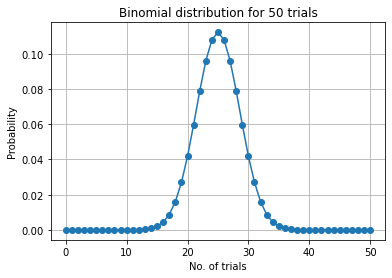

In [16]:
# plot the binomial distribution
plt.plot([i for i in range(TRIALS + 1)], pmf,"-o")
plt.title(f"Binomial distribution for {TRIALS} trials")
plt.xlabel("No. of trials")
plt.ylabel("Probability")
plt.grid(True)

Now we define features are either **extremely important, moderately important or completely unimportant**.

General rule is that: 
- *Extremely Important* features are kept.
- *Moderately Important* features can be played around with
- *Unimportant* features are removed



In [17]:
# select features from n number of trials
def choose_features(feature_hits, TRIALS, thresh):
    
    #define boundries
    green_zone_thresh = TRIALS - thresh
    blue_zone_upper = green_zone_thresh
    blue_zone_lower = thresh
    
    green_zone = [key for key, value in feature_hits.items() if value >= green_zone_thresh]
    blue_zone = [key for key, value in feature_hits.items() if (value >= blue_zone_lower and value < blue_zone_upper)]
    
    return green_zone, blue_zone

In [18]:
thresh = get_tail_items(pmf)
green, blue = choose_features(feature_hits, TRIALS, thresh)

In [19]:
green,blue

(['age', 'avg_glucose_level'], [])